In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
from helpers import *
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider
from safepython import util, plot_functions, PAWN, VBSA, RSA_thres
plt.style.use("default")
plt.rcParams["font.family"] = "sans-serif"

## SFB 1294 - Spring School 2025
# Introduction to Sensitivity Analysis

---
This notebook serves as an introduction to **sensitivity analysis (SA)** using a simple hydrological model called **HyMod**. Sensitivity analysis helps us understand how variations in input parameters affect the outputs of a model. This is crucial for model calibration, uncertainty estimation, and gaining insight into the dominant processes controlling model behavior.

Please click the <span>&#x23E9;</span> button in the menu bar to run all cells before you start reading ...

#### What this Notebook is About
1. **Introduction to HyMod**, a conceptual hydrological model used for predicting river streamflow.
2. **Basic ideas of sensitivity analysis**, including why and how it is performed.
3. **Applications of different SA methods to HyMod** to quantify the influence of model parameters.
4. **How methodological choices influence results**, highlighting that sensitivity analysis is not one-size-fits-all.

#### What This Notebook Does Not Cover
- This is **not** a coding tutorial on how to implement sensitivity analysis from scratch.
- Instead, we will use pre-computed results and guide you through their interpretation.
- If you want to apply these methods in your own work, you can use the [safetoolbox](https://safetoolbox.github.io), which provides SA implementations in Python, R, and Matlab. Example workflows are available there.

---


## Sampling Parameters and Evaluating HyMod

### A Simple Hydrological Model

HyMod is a **conceptual rainfall-runoff model** that simulates streamflow in a river based on meteorological inputs. It is commonly used for educational purposes due to its simplicity and interpretability.

<center>
    <figure>
        <img src="hymod.png" width="75%"/>
    </figure>
</center>

#### Model Inputs
HyMod requires time series observations of two hydrometrological variables:
1. **Precipitation (P)** – The total amount of water input from rainfall and snowfall.
2. **Potential Evapotranspiration (PET)** – The maximum amount of water that can be lost to the atmosphere through evaporation and plant transpiration.

### The Leaf River Catchment

We will use HyMod to simulate streamflow for the **Leaf River**, located in Mississippi, USA.

We have time series for the observed streamflow, precipitation, and potential evapotranspiration between 2010 and 2015. They are stored in the file `leaf.txt`.

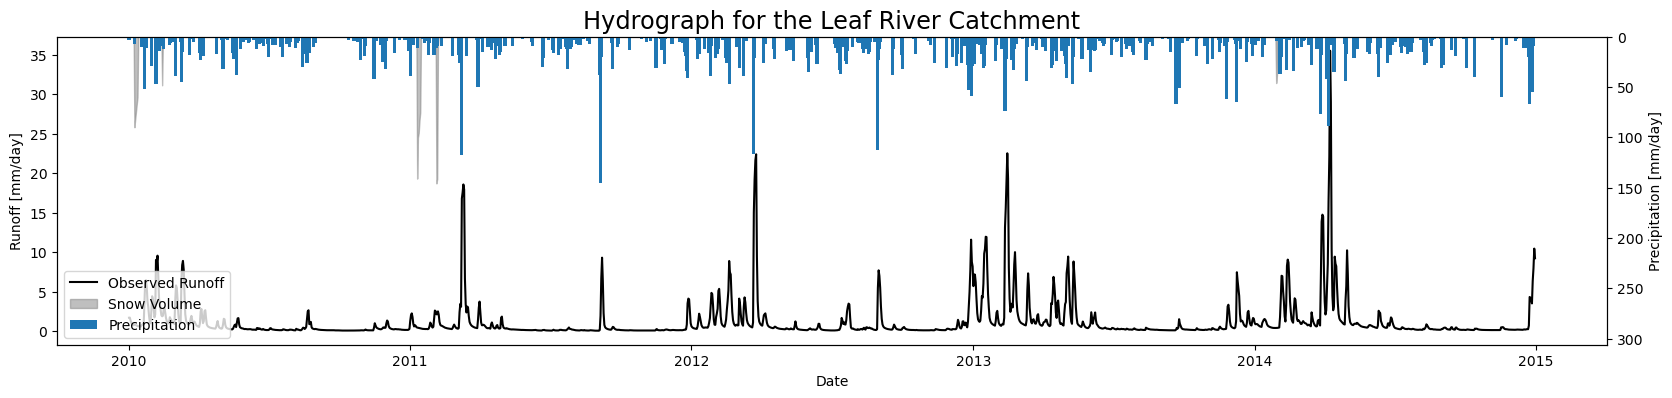

In [9]:
# load the hydrometrological data for the leaf river
df_hydromet = load_catchment_data("leaf.txt")

# plot the hydrograph (e.g. observed discharge, rainfall, snow volume)
plt.figure(figsize=(20, 4))
plot_hydrograph(df_hydromet)
plt.title("Hydrograph for the Leaf River Catchment", fontsize="xx-large")
plt.show()

### Evaluating the Model
We have already run HyMod for many parameter sets sampled from the standard ranges described in the table above. The model simulations are based on the time series of precipitation, potential evapotranspiration and observed runoff that are shown in the hydrograph.

To do the sensitivity analysis, we need to find some way that quanties model performance. This can be done with objective functions that either measure similarity of the model output to some observed data or reflect certain statistical aspects of the output that we are interested with.

For this notebook, we evaluated the performance of HyMod using the following objective functions:

1. **Root Mean Square Error** measures how much the predicted discharge $Q_{sim}$ deviates from observations $Q_{obs}$:
    $$ RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (Q_{sim,i} - Q_{obs,i})^2} $$

2. **Absolute Bias** quantifies whether the model systematically overestimates or underestimates discharge:
    $$ Bias = \frac{1}{N} \sum_{i=1}^{N} \mid Q_{sim,i} - Q_{obs,i}\mid $$

3. **Mean and Standard Deviation of Simulation** only use output of the model and not observations of inputs:
    $$ \bar{Q}_{sim} = \frac{1}{N} \sum_{i=1}^{N} Q_{sim,i} $$
    $$ \sigma_{sim} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (Q_{sim,i} - \bar{Q}_{sim})^2} $$

**Note:** The mean flow and standard deviation metrics are based only on the model output. This demonstrates that sensitivity analysis does **not always require observational data**—it can also be used to purely understand model behavior.

In [10]:
# load the HyMod runs for the Leaf River
n_samples   = 5000
df_runs_all = pd.read_csv("sobol_uniform.csv", compression="zip")
df_runs     = df_runs_all.head(2 * n_samples)
of_names    = df_runs.columns[5:]

display(df_runs_all.head())

,SMAX,BETA,ALPHA,RS,RF,RMSE,Bias,Mean Flow,Flow Std
0,352.974295,0.460664,0.465222,0.018144,0.505887,2.456713,0.713362,1.933467,1.588744
1,238.580668,1.100985,0.391051,0.019402,0.729998,2.562091,1.259544,2.479650,2.002379
2,5.833884,1.775054,0.409576,0.243802,0.977035,5.063773,2.264253,3.484359,5.684476
3,105.641072,0.668099,0.243870,0.219302,0.943317,2.519986,1.144025,2.364130,3.446416
4,141.950540,1.949070,0.239912,0.266550,0.885612,2.987894,1.686470,2.906575,3.727654


The dataframe holds the parameter samples (columbs SMAX, BETA, ALPHA, RS, RF) and the values of the objective functions for the model output produced by the parameter set (columns RMSE, Bias, Mean Flow and Flow Std).

#### Python Workflow to Evaluate a Model

In Python, the general workflow for sampling paramters and evaluating a model could look like this. Additional information on this and implementations in R or Matlab can be found [here](https://github.com/SAFEtoolbox/SAFE-python/tree/main/examples/workflows).

```python
    from safepython import sampling, model_execution

    # define the number of parameters
    n_params = 5

    # define the parameter ranges (0-400, 0-2, ...)
    lower = [0,   0, ...]
    upper = [400, 2, ...]

    # define the number of samples for SA
    n_samples = 1000

    # define the distribution from which to sample
    dist = sp.stats.uniform

    # sample the parameter space using latin-hypercube sampling
    samples = sampling.AAT_sampling("lhs", n_params, dist, [lower, upper - lower], n_samples)

    # evaluate the model
    Y = model_execution.model_execution(objective, samples, ...)
```

---

## What is Sensitivity?

SA methods try to quantify how the performance of a model in terms of an objective depends on input data, model parameters or the model structure.

One naive way to explore sensitivit is to look at scatterplots of the objective function over the parameter values and check whether certain trends and regions of "good" performance are visible. Below, you find partial dependence plots of the model runs for the Leaf River catchment.

If you run this Jupyter Notebook interactively, you can change which objective function is used in the dropdown menu!


In [11]:
@interact(of=Dropdown(options=of_names, description="Objective"))
def plot_scatterplots(of):
    fig, axs = plt.subplots(1, n_params, figsize=(20, 4), sharey="row")
    for i, ax, param in zip(range(n_params), axs, param_names):
        ax.set_xlabel(param)
        ax.set_ylabel(of)
        # scatter the objective function over the parameter value
        sns.scatterplot(df_runs, x=param, y=of, alpha=0.05, color=f"C{i}", ax=ax)
        # plot the partial dependence
        sns.lineplot(df_runs, x=pd.cut(df_runs[param], 20).apply(lambda x: x.mid), y=of, errorbar="ci", color=f"C{i}", ax=ax)
    plt.gcf().suptitle(f"Partial Dependence of {of} on Parameters", fontsize="xx-large")
    plt.show()

interactive(children=(Dropdown(description='Objective', options=('RMSE', 'Bias', 'Mean Flow', 'Flow Std'), val…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>A Naive Approach to Sensitivity</h4>
    <ul>
        <li><i>How could you define sensitivity and which paramters would be influential?</i></li>
        <li><i>How is this reflected in the partial dependence plots?</i></li>
    </ul>
</div>

---

## Regional Sensitivity Analysis
Regional Sensitivity Analysis (RSA) is a screening method used to specifically assess how sensitive a model is to certain ranges of parameter values.

RSA evaluates how different parameter values influence the likelihood of achieving an "acceptable" model performance. Of course, the term acceptable is context dependend and requires some knowledge about the model, its application and the objective function used to evaluate model performance. RSA then identifies which parameters are most influential by examining the difference in their distributions between "good/behavioral" and "poor/nonbehavioral" simulations.

The key steps are:

1. **Define Behavioral and Non-Behavioral Parameter Sets**
    - run the model multiple times with randomly sampled parameter sets and evaluate the model output using an objective function (we already did this)
    - define a threshold for acceptable performance (you can do this for the plot below)
2. **Compare the Cumulative Distribution Functions (CDFs)**
    - compute the empirical **Cumulative Distribution Functions (CDFs)** for the behavioral and non-behavioral parameter sets.
    - a large difference in CDFs indicates that a parameter has a strong influence on model performance.
3. **Calculate the Kolmogorov-Smirnov (KS) Distance**
    - the KS distance is used to quantify the difference between the two CDFs.
    - parameters with higher KS distances are more influential, as their distributions differ significantly between behavioral and non-behavioral sets.
    - parameters with lower KS distances have little effect on model performance.

In [12]:
@interact(of=Dropdown(options=of_names, description="Objective"), threshold=FloatSlider(min=0, max=1, value=0.05, step=0.01, description="Threshold"))
def plot_RSA(of, threshold=0.05):

    # calculate the threshold value for the selected statistic
    threshold  = df_runs[of].quantile(threshold)
    behavioral = df_runs[of] <= threshold
    behavioral.name = "Behavioral"

    # PLOT 1: Behavioral and Nonbehavioral Parameter Sets
    fig, axs = plt.subplots(1, n_params, figsize=(20, 4), sharey="row")
    for i, ax, param in zip(range(n_params), axs, param_names):
        ax.set_xlabel(param)
        ax.set_ylabel(of)
        # scatter the behavioral and nonbehavioral parameters
        sns.scatterplot(df_runs, x=param, y=of, hue=behavioral, hue_order=(False, True), alpha=0.1, palette=sns.color_palette(["gray", f"C{i}"]), ax=ax)
        sns.move_legend(ax, loc="upper right")
        # indicator of the threshold
        ax.axhline(threshold, color="black", ls="--")
        ax.text(0.5, threshold, f"{of}={threshold:.2f}", va="center", ha="center", backgroundcolor="white", transform=ax.get_yaxis_transform())
    plt.gcf().suptitle(f"Behavioral and Nonbehavioral Parameters", fontsize="xx-large")
    plt.show()

    # PLOT 2: CDFs
    fig, axs = plt.subplots(1, n_params, figsize=(20, 4), sharey="row")
    for i, ax, param in zip(range(n_params), axs, param_names):
        ax.set_xlabel(param)
        ax.set_ylabel("CDF")
        # cumulative distributions of the behavioral and nonbehavioral runs
        sns.ecdfplot(df_runs, x=param, hue=behavioral, hue_order=(False, True), palette=sns.color_palette(["gray", f"C{i}"]), ax=ax)
        # rugplot of the behavioral parameters
        sns.rugplot(x=df_runs[param][behavioral], alpha=0.1, color=f"C{i}", ax=ax)
        # the KS statistic
        ks  = sp.stats.ks_2samp(df_runs[param][behavioral], df_runs[param][~behavioral])
        cdf = sp.stats.ecdf(df_runs[param][behavioral]).cdf.evaluate(ks.statistic_location)
        ax.vlines(ks.statistic_location, cdf, cdf - ks.statistic*ks.statistic_sign, color=f"C{i}", ls="--")

    plt.gcf().suptitle(f"Kolmogorow-Smirnow Distance as a Measure of Sensitivity", fontsize="xx-large")
    plt.show()

interactive(children=(Dropdown(description='Objective', options=('RMSE', 'Bias', 'Mean Flow', 'Flow Std'), val…

Change the quantile threshold to see how the distribution of the behavioral and non-behavioral parameter sets changes. You can also choose the objective function from the dropdown menu. Later plots will also show you differences between the objective functions.

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>The Kolmogorow-Smirnow Distance as a Measure of Sensitivity</h4>
    <ul>
        <li><i>How does the KS distance relate to the partial dependence plots you have already seen?</i></li>
        <li><i>How do the distributions of behavioral and non-behavioral paramter sets depend on the objective function?</i></li>
        <li><i>Can RSA also show you optimal parameter ranges?</i></li>
    </ul>
</div>

In [16]:
@interact(threshold=FloatSlider(min=0, max=1, value=0.05, step=0.01, description="Threshold"), n_boot=IntSlider(min=5, max=100, value=5, description="Bootstraps"))
def plot_RSA_all_objectives(threshold=0.05, n_boot=5):

    fig, axs = plt.subplots(1, len(of_names), figsize=(20, 4), sharey="row")

    for i, of in enumerate(of_names):

        # calculate the RSA indices
        SI, _, _, _ = RSA_thres.RSA_indices_thres(df_runs[param_names].to_numpy(), df_runs[of].to_numpy(), threshold=df_runs[of].quantile(threshold), Nboot=n_boot)

        # PLOT 1: boxplot of the sensitivity indices
        plt.sca(axs[i])
        plt.title(of)
        plt.ylabel("Sensitivity Index (KS Distance)")
        plot_indices(SI)
        plt.xticks(range(n_params), param_names)

    plt.gcf().suptitle("RSA: Parameter Importance for Different Objectives", fontsize="xx-large", y=1.05)
    plt.show()

interactive(children=(FloatSlider(value=0.05, description='Threshold', max=1.0, step=0.01), IntSlider(value=5,…

These plots show the KS distance as a measure of sensitivity for different objective functions. You can again vary which parameter sets are considered as behavioral or non-behavioral by changing the quantile threshold. As you can see, the results of the RSA depend on the objective function that is used.

#### Confidence Intervals

We derive confidence intervals by resampling from the parameters sets and calculating the statistic independently for each resample. This is called bootstrapping and gives us an approximate distribution of the sensitivity index (in this case the KS distance). 

You can change the number of bootstrap samples to see how the confidence intervals change. **The RSA applet may take some time to run!**

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>RSA Results Depend on Objective Function</h4>
    <ul>
        <li><i>Do different objective functions find different parameters to be influential?</i></li>
        <li><i>Can you spot differences and similarities?</i></li>
        <li><i>How does the number of bootstrap samples affect you confidence in the results?</i></li>
    </ul>
</div>

#### Python Workflow for RSA

In Python, the general workflow for performing a RSA could look like this. It continues the parameter sampling workflow seen above. Additional information on this and implementations in R or Matlab can be found [here](https://github.com/SAFEtoolbox/SAFE-python/tree/main/examples/workflows).

```python
from safepython import RSA_thresh

# define the threshold for behavioral and non-behavioral runs
threshold = 0.05

# define the number of bootstrap samples
n_boot = 20

# calculate the RSA indices
SI, _, _, _ = RSA_thres.RSA_indices_thres(samples, objectives, threshold=threshold, Nboot=n_boot)
```
---

## Variance Based Sensitivity Analysis

Variance Based Sensitivity Analysis (VBSA) is a global sensitivity analysis method that quantifies how much of the variance in a model’s output can be attributed to each input parameter. Unlike screening methods like RSA, VBSA provides quantitative sensitivity indices that account for both individual and interaction effects of parameters.

VBSA relies on the decomposition of the total variance of model output into contributions from individual parameters and their interactions. For an output function $Y = f(X_1, X_2, ..., X_n)$, such as the RMSE or bias, the total variance can be decomposed as:
$$
     V(Y) = \sum_{i} V_i + \sum_{i < j} V_{ij} + \sum_{i < j < k} V_{ijk} + \dots
$$

where:
 - $V(Y)$ is the total variance of the model output.
 - $V_i$ is the contribution of parameter $X_i$ alone (first-order effect).
 - $V_{ij}$ represents interactions between parameters $X_i$ and $X_j$, and so on.

The **First-Order Sensitivity Index** measures only the direct effect of a parameter on the output variance. It is defined as:
$$
S_i = \frac{V_i}{V(Y)}
$$

The **Total Sensitivity Index** accounts for both the direct effect and interactions of one parameter with other parameters.
$$
     S_{Ti} = \frac{V_i + \sum_j V_{ij} + \sum_{jk} V_{ijk} + \cdots}{V(Y)} = \frac{V(Y) - V_{\sim i}}{V(Y)}
$$
where $V_{\sim i}$ includes all terms that do not involve the parameter $X_i$. The effect of parameter interactions can be calculated as the difference $S_{Ti} - S_i$.

The conditional variances can not be calculated directly and need to be estimated from the distribution of the objective function. Different estimators are described by [Saltelli et. al. 2010](https://doi.org/10.1016/j.cpc.2009.09.018). A general overview of VBSA is given in his book ["Global Sensitivity Analysis: The Primer"](https://www.andreasaltelli.eu/file/repository/A_Saltelli_Marco_Ratto_Terry_Andres_Francesca_Campolongo_Jessica_Cariboni_Debora_Gatelli_Michaela_Saisana_Stefano_Tarantola_Global_Sensitivity_Analysis_The_Primer_Wiley_Interscience_2008_.pdf) starting at page 155.

In [14]:
@interact(n_samples_emulate=IntSlider(min=100, max=n_samples, value=5000, description="Samples"), n_boot=IntSlider(min=5, max=100, value=20, description="Bootstraps"))
def plot_vbsa(n_samples_emulate=n_samples, n_boot=20):

    fig, axs = plt.subplots(1, len(of_names), figsize=(20, 4), sharey="row")

    for i, of in enumerate(of_names):

        # resample from the original run to fake effect of reduced sample number
        idx = np.arange(n_samples) < n_samples_emulate
        Y   = df_runs_all[of].copy().to_numpy()
        Y   = (Y - Y.mean())/Y.std()
        A, B, AB = Y[slice(None, n_samples)][idx], Y[slice(n_samples, 2 * n_samples)][idx], Y[slice(2 * n_samples, None)][np.tile(idx, n_params)]

        # calculate the sobol indices
        SI_direct, SI_total = VBSA.vbsa_indices(A, B, AB, n_params, Nboot=n_boot)

        # PLOT 1: boxplot of the sensitivity indices
        plt.sca(axs[i])
        plot_indices(SI_direct, positions=[i - 0.2 for i in range(n_params)])
        plot_indices(SI_total - SI_direct, positions=[i + 0.2 for i in range(n_params)], boxstyle={"hatch": "xxx"})
        # plt.ylim([0, 1])
        plt.xticks(range(n_params), param_names)
        plt.ylabel("Sensitivity Index")
        plt.title(of)
        # add a custom legend
        handles = [plt.matplotlib.patches.Patch(color="gray"), plt.matplotlib.patches.Patch(color="gray", hatch="xxx", ec="white")]
        labels  = ["Direct Effect", "Interactions"]
        plt.legend(handles, labels)

    plt.gcf().suptitle("VBSA: Parameter Importance for Different Objectives", fontsize="xx-large", y=1.05)
    plt.show()

interactive(children=(IntSlider(value=5000, description='Samples', max=5000, min=100), IntSlider(value=20, des…

These plots show the direct effects (solid) and interactions (hatched) of the parameters for the objective functions. You can change the number of samples used for the VBSA to see how the results change and the number of bootstrap samples that are used to derive confidence intervals.

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Direct Effect and Parameter Interactions</h4>
    <ul>
        <li><i>Which parameters are influential according to their direct effect?</i></li>
        <li><i>Which parameters show strong interactions?</i></li>
        <li><i>Does VBSA find the same influential parameters as RSA did?</i></li>
        <li><i>How does the number of samples affect the sensitivity index distribution?</li>
    </ul>
</div>


### VBSA Depends on Parameter Distribution

In [15]:
dfs = {
    "Uniform"   : pd.read_csv("sobol_uniform.csv"        , compression = "zip"),
    "Half-Range": pd.read_csv("sobol_half.csv"           , compression = "zip"),
    "Normal"    : pd.read_csv("sobol_normal.csv"         , compression = "zip"),
    "Behavioral": pd.read_csv("sobol_behavioral_rmse.csv", compression = "zip")
}

@interact(of=Dropdown(options=of_names, description="Objective"), param=Dropdown(options=param_names, description="Parameter"), n_boot=IntSlider(min=5, max=100, value=20, description="Bootstraps"))
def plot_VBSA_distribution(of="RMSE", param="SMAX", n_boot=20):

    # PLOT 1: Parameter Distribution
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for ax, dist in zip(axs, dfs.keys()):
        j = param_names.index(param)
        sns.histplot(dfs[dist], x=param, binrange=ranges[j], bins=50, color=f"C{j}", ax=ax)
        ax.set_title(dist)
    plt.gcf().suptitle("Parameter Distributions", fontsize="xx-large", y=1.05)
    plt.show()

    # PLOT 2: Sensitivity Indices
    fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey="row")
    for ax, dist in zip(axs, dfs.keys()):
        # load the objectives
        Y = dfs[dist][of].to_numpy()
        Y = (Y - Y.mean())/Y.std()
        n = int(len(Y)/(n_params + 2))
        A, B, AB = Y[slice(None, n)], Y[slice(n, 2 * n)], Y[slice(2 * n, None)]
        # calculate the sobol indices
        SI_direct, SI_total = VBSA.vbsa_indices(A, B, AB, n_params, Nboot=n_boot)
        # boxplot of the sensitivity indices
        plt.sca(ax)
        plot_indices(SI_direct, positions=[i - 0.2 for i in range(n_params)])
        plot_indices(SI_total - SI_direct, positions=[i + 0.2 for i in range(n_params)], boxstyle={"hatch": "xxx"})
        plt.xticks(range(n_params), param_names)
        plt.ylabel("Sensitivity Index")
        plt.title(dist)
        # add a custom legend
        handles = [plt.matplotlib.patches.Patch(color="gray"), plt.matplotlib.patches.Patch(color="gray", hatch="xxx", ec="white")]
        labels  = ["Direct Effect", "Interactions"]
        plt.legend(handles, labels)
    plt.gcf().suptitle("Sensitivity Indices Depending on Parameter Distribution", fontsize="xx-large", y=1.05)
    plt.ylim([0, plt.ylim()[1]])
    plt.show()

interactive(children=(Dropdown(description='Objective', options=('RMSE', 'Bias', 'Mean Flow', 'Flow Std'), val…

Finally, we look at how VBSA indices are affected by you choice of parameter distribution. For this, we have run VBSA for parameter sets samples from the the original uniform, half-range uniform, truncated normal and behavioral distribution. The behavioral distribution only includes the 5% best parameter sets in terms of RMSE.

In the applet, you can again change the objective that is used to evaluate model performance and the number of bootstrap samples to estimate the uncertainty range of sensitivity indices. The individual parameter distributions are only for illustration.

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>VBSA shows Direct Effect and Parameter Interactions</h4>
    <ul>
        <li><i>Are there differences between the sensitivity indices for different parameter distributions?</i></li>
        <li><i>In which context would you perform VBSA only for the behavioral parameter sets?</i></li>
    </ul>
</div>

#### Python Workflow for VBSA

In Python, the general workflow for performing a VBSA could look like this. It continues the parameter sampling workflow seen above. Additional information on this and implementations in R or Matlab can be found [here](https://github.com/SAFEtoolbox/SAFE-python/tree/main/examples/workflows).

```python
from safepython import VBSA

# define the number of bootstrap samples
n_boot = 20

# sample the parameter space using latin-hypercube sampling
samples = sampling.AAT_sampling("lhs", n_params, dist, [lower, upper - lower], 2*n_samples)

# resample for VBSA analysis
samples_A, samples_B, samples_AB = VB.vbsa_resampling(X)

# evaluate the model
YA, YB, YAB = [model_execution.model_execution(objective, samples, ...) for samples in (samples_A, samples_B, samples_AB)]

# calculate direct and total effects
SI_direct, SI_total = VB.vbsa_indices(YA, YB, YAB, n_params)
```